In [310]:
import argparse
import sys
import time
import os
import math

import numpy as np

from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms

import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from itertools import product
import copy


In [311]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [312]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.seed = 123
args.val_size = 0.1
args.test_size = 0.1
args.shuffle = True

In [313]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')


In [314]:
# file 이름 형태: id+object_label1,object_label2+style_label1,style_label2+material_label1,material_label2.jpg
def read_data_from_file(file_path):
  file_list = os.listdir(file_path)
  ids = []
  artwork_labels_list = [[] for _ in range(3)]

  for file_name in file_list:
    # .jpg 제거
    file_name = file_name[0: len(file_name) - 4]
    parsing_list = file_name.split('+')
    if (parsing_list[0] == ''):
        continue
    ids.append(parsing_list[0])
    del parsing_list[0]

    for i, label in enumerate(parsing_list):
        label = label.lower()
        label_list = label.split(', ')
        label_list = list(filter(None, label_list))
        artwork_labels_list[i].append(label_list)
        
  artworks = pd.DataFrame(
      {"ID": ids, "object_labels": artwork_labels_list[0], "style_labels": artwork_labels_list[1], "material_labels": artwork_labels_list[2], "File": file_list})
  artworks.dropna()
  
  return artworks


def filterLabelsByFrequency(artworks, frequency):
  for column in artworks.filter(regex='labels'):
    label_freq = artworks[column].apply(
      lambda s: [x for x in s]).explode().value_counts().sort_values(ascending=False)

    # Create a list of rare labels
    rare = list(label_freq[label_freq < frequency].index)

    artworks[column] = artworks[column].apply(
      lambda s: [x for x in s if x not in rare])
    artworks[column] = artworks[column].apply(
      lambda s: s if len(s) != 0 else np.nan)

  artworks.dropna(inplace=True)
  return artworks


   ID           object_labels                    style_labels material_labels  \
0  10  [allegorical painting]  [mannerism (late renaissance)]   [oil, canvas]   
1  11  [allegorical painting]  [mannerism (late renaissance)]     [oil, wood]   
2  12  [allegorical painting]  [mannerism (late renaissance)]   [oil, canvas]   
3  13  [allegorical painting]  [mannerism (late renaissance)]     [oil, wood]   
4  14  [allegorical painting]  [mannerism (late renaissance)]   [oil, canvas]   
5   5  [allegorical painting]  [mannerism (late renaissance)]   [oil, canvas]   
6   6  [allegorical painting]  [mannerism (late renaissance)]   [oil, canvas]   
7   7    [religious painting]  [mannerism (late renaissance)]   [oil, canvas]   
8   8  [allegorical painting]  [mannerism (late renaissance)]   [oil, canvas]   
9   9    [religious painting]  [mannerism (late renaissance)]   [oil, canvas]   

                                                File  
0  10+allegorical painting+Mannerism (Late Renais... 

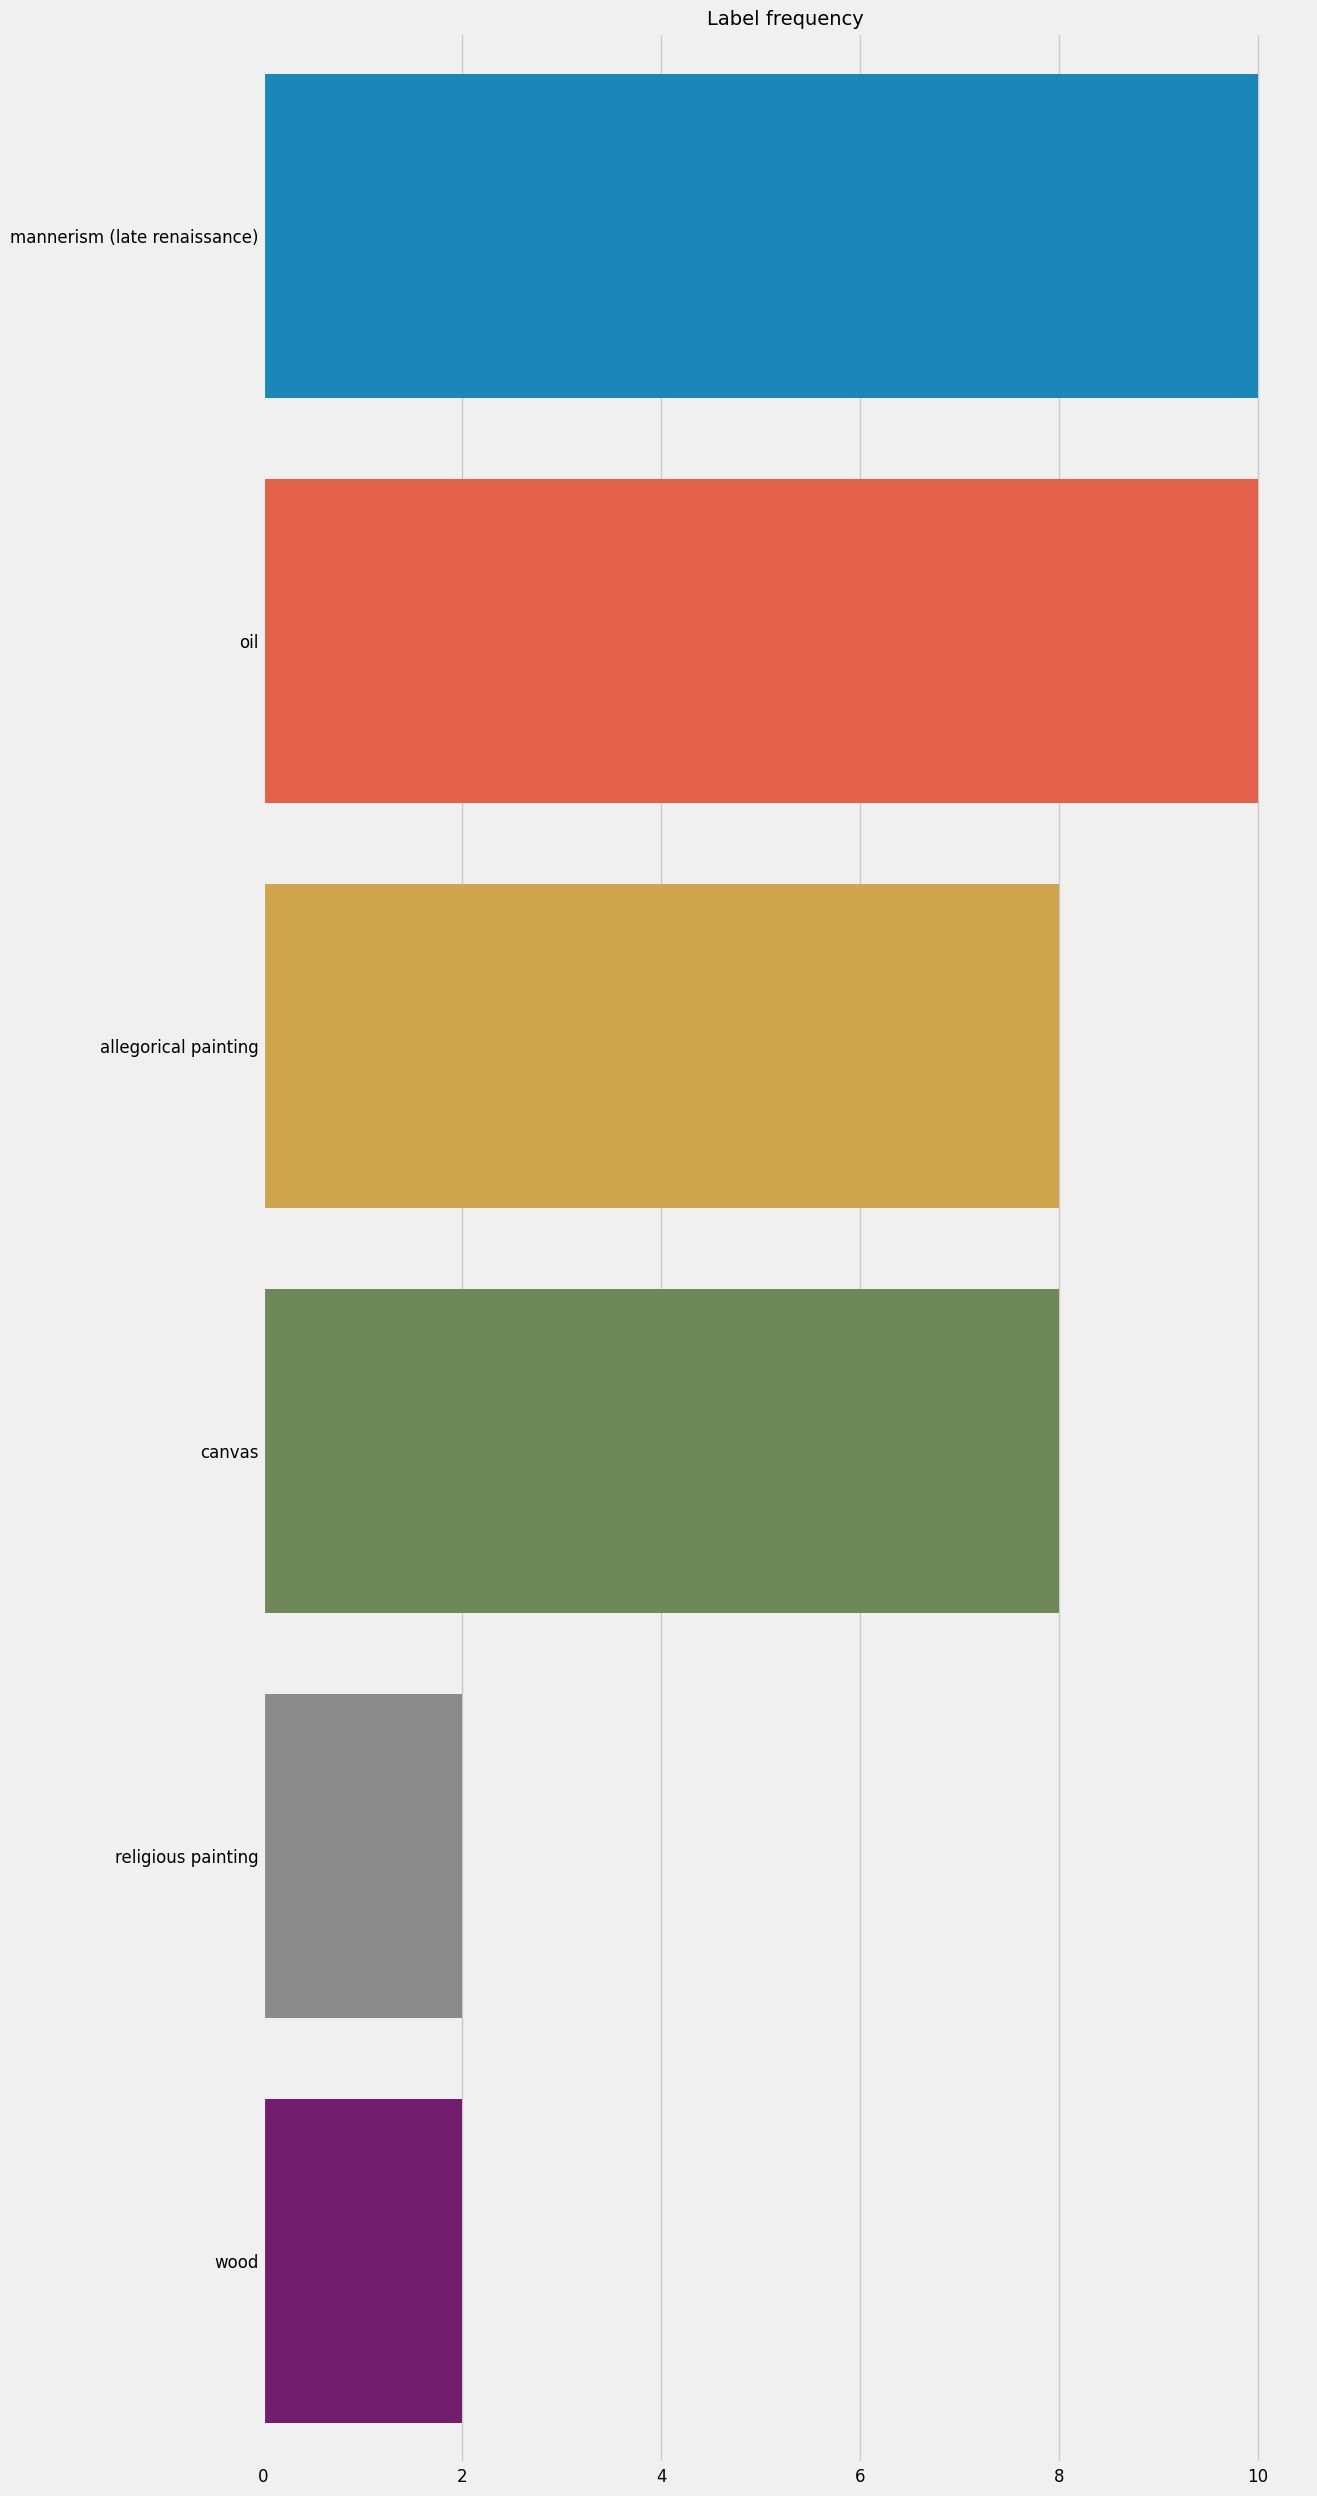

In [315]:
artworks = read_data_from_file('./database_test')
artworks = filterLabelsByFrequency(artworks, 0)
print(artworks)

object_label_freq = artworks['object_labels'].apply(
    lambda s: [x for x in s]).explode().value_counts()
style_label_freq = artworks['style_labels'].apply(
    lambda s: [x for x in s]).explode().value_counts()
material_label_freq = artworks['material_labels'].apply(
    lambda s: [x for x in s]).explode().value_counts()

label_freq = pd.concat([object_label_freq, style_label_freq,
                       material_label_freq]).sort_values(ascending=False)

style.use("fivethirtyeight")
plt.figure(figsize=(12, 30))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [316]:
def count_labels(label_list):
    total_labels = []
    for labels in label_list:
      labels = list(filter(None, labels))
      total_labels.extend(labels)

    return len(list(set(total_labels))), list(set(total_labels))


def get_index_of_np(numpy, val):
  index_np = np.where(numpy == val)[0]

  if index_np.size != 1:
    print('a', index_np[0], index_np.size, val)
    return None
  else:
    return index_np[0]
  
def get_adjacency_matrix(artwork_labels_list, total_labels, N_LABEL):
  adjacency_matrix = np.zeros((N_LABEL, N_LABEL))
  
  for artwork_labels in artwork_labels_list:
    label_combinations = list(product(artwork_labels, repeat=2))
    
    for label_combination in label_combinations:
      pivot_index = get_index_of_np(total_labels, label_combination[0])
      target_index = get_index_of_np(total_labels, label_combination[1])
      if (pivot_index is None) or (target_index is None):
        return None
      else:
        adjacency_matrix[pivot_index][target_index] += 1

  for row_index, row in enumerate(adjacency_matrix):
    basis = row[row_index]
    for col_index, val in enumerate(row):
      row[col_index] = val/basis
    
  return adjacency_matrix


def get_feature_matrix():
  return

def convert_to_graph(artworks):
  label_classes = ['object_labels', 'style_labels', 'material_labels']
  artwork_labels_list=[]
  labels_list_by_class = [set() for _ in range(3)]

  for index, label_class in enumerate(label_classes):
    labels_group = artworks[label_class]

    if index == 0:
      for labels in labels_group:
        artwork_labels_list.append(copy.deepcopy(labels))
        labels_list_by_class[index] = labels_list_by_class[index].union(set(copy.deepcopy(labels)))
    else:
      for i, labels in enumerate(labels_group):
        artwork_labels_list[i].extend(copy.deepcopy(labels))
        labels_list_by_class[index] = labels_list_by_class[index].union(
            set(copy.deepcopy(labels)))
  
  N_LABEL, total_labels = count_labels(artwork_labels_list)
  adjacency_matrix = get_adjacency_matrix(
      artwork_labels_list, np.array(total_labels), N_LABEL)
  
  class_one_hot_encoding_matrix = np.zeros((N_LABEL, 3))

  for i in range(N_LABEL):
    label = total_labels[i]
    for j in range(3):
      class_one_hot_encoding_matrix[i][j] = np.any(
          np.array(list(labels_list_by_class[j])) == label)
  
  embedding = nn.Embedding(N_LABEL, embedding_dim=5)
  input = torch.tensor(range(len(total_labels)))
  word_embedding_matrix = embedding(input).detach().cpu().numpy()
  
  feature_matrix = np.concatenate((class_one_hot_encoding_matrix, word_embedding_matrix), axis=1)
  
  return adjacency_matrix, feature_matrix, N_LABEL, total_labels


In [317]:
adjacency_matrix, feature_matrix, N_LABEL, total_labels = convert_to_graph(
    artworks)

In [318]:
artworks['labels'] = artworks['object_labels'] + artworks['style_labels'] + artworks['material_labels']

dataset_size = len(artworks)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.2)
test_size = int(validation_size * 0.5)

X_train, X_val, y_train, y_val = train_test_split(
    artworks['File'], artworks['labels'], test_size=0.2, random_state=23)
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=0.5, random_state=23)

X_train = [os.path.join('./database_test', str(f)) for f in X_train]
X_val = [os.path.join('./database_test', str(f)) for f in X_val]
X_test = [os.path.join('./database_test', str(f)) for f in X_test]

label_list = pd.DataFrame({'labels': [total_labels]})
mlb = MultiLabelBinarizer()
mlb.fit(label_list['labels'])

y_train = list(y_train)
y_val = list(y_val)
y_test = list(y_test)
y_train_bin = mlb.transform(y_train).astype(np.float64)
y_val_bin = mlb.transform(y_val).astype(np.float64)
y_test_bin = mlb.transform(y_test).astype(np.float64)

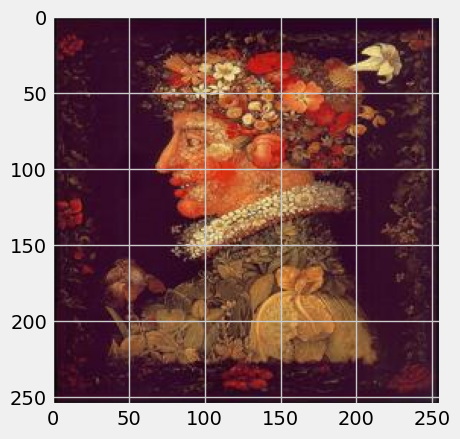

In [319]:
from PIL import Image
sample_image = Image.open(X_train[0])
plt.imshow(sample_image, cmap='gray')


In [320]:
class CustomDataset(Dataset):
  def __init__(self, mode, img_list, label_list=None):
    super(CustomDataset, self).__init__()
    self.mode = mode
    self.img_list = img_list
    self.label_list = label_list
  
  def __len__(self):
    return len(self.img_list)
  
  def __getitem__(self, index):
    x_data = self.img_list[index]
    x_data = np.transpose(x_data, (2, 0, 1))  # (H, W, C) -> (C, H, W)
    if self.mode == 'train':
      return {
          'X': torch.tensor(x_data, dtype=torch.float),
        'Y': np.array(self.label_list[index])
      }
    else:
      return {'X': torch.tensor(x_data, dtype=torch.float)}


In [321]:
def get_img_list(series):
  image_list = []
  for file_path in series:
    image = Image.open(file_path)
    image_array = np.array(image)
    image_list.append(image_array)

  return image_list

In [322]:
class ArtworksDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        img = Image.open(self.X[index]).convert('RGB')
        label = torch.tensor(self.y[index], dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, label


In [334]:
# def get_dataloader(x, y, batch_size, mode='train'):
#     shuffle = True if mode == 'train' else False
#     img_list = get_img_list(x)
#     dataset = CustomDataset(mode=mode, img_list=img_list, label_list=y)
#     dataloader = DataLoader(
#         dataset=dataset, batch_size=batch_size, shuffle=shuffle, generator=torch.Generator(device=device))
#     total_batch = math.ceil(len(dataset)/batch_size)

#     return dataloader, total_batch
# Define data loader
def get_dataloader(X, y, batch_size, mode='train'):
    if mode == 'train':
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    dataset = ArtworksDataset(X, y, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size,
                            shuffle=True, generator=torch.Generator(device=device))
    total_batch = len(dataloader)
    return dataloader, total_batch


In [324]:
class GCNLayer(nn.Module):
  def __init__(self, in_dim, out_dim, n_label, act=None, bn=False):
    super(GCNLayer, self).__init__()

    self.use_bn = bn
    self.linear = nn.Linear(in_dim, out_dim)
    nn.init.xavier_uniform(self.linear.weight)
    self.bn = nn.BatchNorm1d(n_label)
    self.activation = act

  def forward(self, x, adj):
    out = self.linear(x)
    out = torch.matmul(adj, out)
    if self.use_bn:
      out = self.bn(out)
    if self.activation != None:
      out = self.activation(out)

    return out, adj

In [325]:
class GatedSkipConnection(nn.Module):
  def __init__(self, in_dim, out_dim):
    super(GatedSkipConnection, self).__init__()

    self.in_dim = in_dim
    self.out_dim = out_dim

    self.linear = nn.Linear(in_dim, out_dim, bias=False)
    self.linear_coef_in = nn.Linear(out_dim, out_dim)
    self.linear_coef_out = nn.Linear(out_dim, out_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self, in_x, out_x):
    if (self.in_dim != self.out_dim):
        in_x = self.linear(in_x)
    z = self.gate_coefficient(in_x, out_x)
    out = torch.mul(z, out_x) + torch.mul(1.0-z, in_x)
    return out

  def gate_coefficient(self, in_x, out_x):
    x1 = self.linear_coef_in(in_x)
    x2 = self.linear_coef_out(out_x)
    return self.sigmoid(x1+x2)

In [326]:
class GCNBlock(nn.Module):
  def __init__(self, n_layer, in_dim, hidden_dim, out_dim, n_atom, bn=True, sc='gsc'):
    super(GCNBlock, self).__init__()

    self.layers = nn.ModuleList()
    for i in range(n_layer):
        self.layers.append(GCNLayer(in_dim if i == 0 else hidden_dim,
                                    out_dim if i == n_layer-1 else hidden_dim,
                                    n_atom,
                                    nn.ReLU() if i != n_layer-1 else None,
                                    bn))
    self.relu = nn.ReLU()
    if sc == 'gsc':
        self.sc = GatedSkipConnection(in_dim, out_dim)
    elif sc == 'no':
        self.sc = None
    else:
        assert False, "Wrong sc type."

  def forward(self, x, adj):
    residual = x
    for i, layer in enumerate(self.layers):
        out, adj = layer((x if i == 0 else out), adj)
    if self.sc != None:
        out = self.sc(residual, out)
    out = self.relu(out)
    return out, adj

In [327]:
class InceptionModule(nn.Module):
  def __init__(self, n_layer, in_dim, hidden_dim, out_dim, n_atom, bn=True, sc='gsc'):
    super(InceptionModule, self).__init__()
    self.GCNBlocks = nn.ModuleList()
    for i in range(n_layer):
      self.GCNBlocks.append(GCNBlock(i,
                                    in_dim,
                                    hidden_dim,
                                    out_dim))
  def forward(self, x, adj):
    outs = []
    for i, block in enumerate(self.GCNBlocks):
      outs.append(block(x, adj))

    feature_concatenate = torch.cat(outs, 2)
    return feature_concatenate, adj

In [328]:
class ReadOut(nn.Module):

    def __init__(self, in_dim, out_dim, act=None):
        super(ReadOut, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.linear = nn.Linear(self.in_dim,
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act

    def forward(self, x):
        out = self.linear(x)
        out = torch.sum(out, 1)
        if self.activation != None:
            out = self.activation(out)
        return out

In [329]:
class GCNNet(nn.Module):
  def __init__(self, args):
    super(GCNNet, self).__init__()


In [330]:
from torchvision import models
resnet50 = models.resnet50(pretrained=True)
fc_input_num_ftrs = resnet50.fc.in_features
print(resnet50.fc)
resnet50.fc = nn.Linear(fc_input_num_ftrs, N_LABEL)
resnet50 = resnet50.to(device)

Linear(in_features=2048, out_features=1000, bias=True)


C:\Users\이성준\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\이성준\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [331]:
# def train(model, criterion, optimizer, batch_size, scheduler, num_epochs=30):
#   train_dataloader, train_total_batch = get_dataloader(
#       X_train, y_train_bin, batch_size, 'train')

#   for epoch in tqdm.tqdm_notebook(range(num_epochs)):
#     model.train()
#     train_avg_loss = 0
#     for batch in train_dataloader:
#       train_X = batch['X'].to(device)
#       train_Y = batch['Y'].to(device)

#       print(train_X.shape)
#       optimizer.zero_grad()
#       hypothesis = model(train_X)
#       loss = criterion(hypothesis, train_Y)
#       loss.backward()
#       optimizer.step()

#       train_avg_loss += loss / train_total_batch
#       scheduler.step()

#   return model

In [332]:
# optimizer_ft = optim.Adam(
#     filter(lambda p: p.requires_grad, resnet50.parameters()), lr=0.001)
# exp_lr_scheduler = optim.lr_scheduler.StepLR(
#     optimizer_ft, step_size=7, gamma=0.1)
# criterion = nn.CrossEntropyLoss()
# model_resnet = train(resnet50, criterion, optimizer_ft, 1,
#                      exp_lr_scheduler)


In [335]:
# Define the model architecture
class Resnet50(nn.Module):
    def __init__(self, n_label):
        super(Resnet50, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, n_label)

    def forward(self, x):
        x = self.resnet(x)
        return x


def train(model, criterion, optimizer, batch_size, scheduler, num_epochs):
    train_loader, train_total_batch = get_dataloader(
        X_train, y_train_bin, batch_size, 'train')
    train_loss = []
    train_acc = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) >= 0.5
            running_corrects += torch.sum(preds == labels.data)
        scheduler.step()
        epoch_loss = running_loss / train_total_batch
        epoch_acc = running_corrects.double() / train_total_batch
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        print('Epoch {}/{} \t train_loss: {:.4f} \t train_acc: {:.4f}'.format(
            epoch+1, num_epochs, epoch_loss, epoch_acc))
    return model, train_loss, train_acc


# Define the model, optimizer and loss function
model_resnet = Resnet50(N_LABEL).to(device)
optimizer_ft = optim.Adam(model_resnet.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
criterion = nn.MultiLabelSoftMarginLoss()

# Train the model
model_resnet, train_loss, train_acc = train(
    model_resnet, criterion, optimizer_ft, 32, exp_lr_scheduler, 10)


Epoch 1/10 	 train_loss: 5.9654 	 train_acc: 23.0000
Epoch 2/10 	 train_loss: 2.2321 	 train_acc: 48.0000
Epoch 3/10 	 train_loss: 0.7202 	 train_acc: 48.0000
Epoch 4/10 	 train_loss: 0.4638 	 train_acc: 48.0000
Epoch 5/10 	 train_loss: 0.1033 	 train_acc: 48.0000
Epoch 6/10 	 train_loss: 0.0626 	 train_acc: 48.0000
Epoch 7/10 	 train_loss: 0.0353 	 train_acc: 48.0000
Epoch 8/10 	 train_loss: 0.0284 	 train_acc: 48.0000
Epoch 9/10 	 train_loss: 0.0248 	 train_acc: 48.0000
Epoch 10/10 	 train_loss: 0.0250 	 train_acc: 48.0000
